<a href="https://colab.research.google.com/github/SamuelKao/WhereToGo/blob/main/WhereAreYouGoing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install holidays

# Import statements

In [34]:
import pandas as pd
from datetime import datetime, date
import numpy as np
import holidays
import os

# Loading data



Around 30 million rows and 19 columns seems to be the limit

In [35]:
# Assuming the file is in the current working directory
#df = pd.read_parquet('/content/drive/My Drive/CSE151GP/data/yellow_tripdata_2023-03.parquet')
#print(df.head(10))

df_list = []

file_names = [f'/content/drive/My Drive/CSE151GP/data/yellow_tripdata_2023-{month:02}.parquet' for month in range(1, 13)]

total_rows = 0

for file_name in file_names:
  try:
    df = pd.read_parquet(file_name)
    df_list.append(df)
    total_rows += df.shape[0]
  except FileNotFoundError:
    print(f"File not found: {file_name}")

print(f"Total number of rows in all files: {total_rows}")



Total number of rows in all files: 38310226


In [36]:
print(df_list[0].head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:32:10   2023-01-01 00:40:36              1.0   
1         2  2023-01-01 00:55:08   2023-01-01 01:01:27              1.0   
2         2  2023-01-01 00:25:04   2023-01-01 00:37:49              1.0   
3         1  2023-01-01 00:03:48   2023-01-01 00:13:25              0.0   
4         2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.97         1.0                  N           161           141   
1           1.10         1.0                  N            43           237   
2           2.51         1.0                  N            48           238   
3           1.90         1.0                  N           138             7   
4           1.43         1.0                  N           107            79   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [37]:
df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [38]:
df_list[1].describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.913955e+06,2913955,2913955,2.837138e+06,2.913955e+06,2.837138e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.837138e+06,2.837138e+06
mean,1.731282e+00,2023-02-15 00:38:01.639923,2023-02-15 00:54:02.594499,1.352847e+00,3.868058e+00,1.514554e+00,1.662570e+02,1.642317e+02,1.182896e+00,1.822038e+01,1.560472e+00,4.878752e-01,3.384825e+00,5.113983e-01,9.813052e-01,2.689848e+01,2.285299e+00,9.677754e-02
min,1.000000e+00,2008-12-31 23:05:06,2008-12-31 23:31:24,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-7.540500e+02,-7.500000e+00,-5.000000e-01,-9.300000e+01,-5.700000e+01,-1.000000e+00,-7.575500e+02,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,2023-02-08 08:43:13,2023-02-08 08:59:34,1.000000e+00,1.060000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.548000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2023-02-14 22:33:21,2023-02-14 22:48:15,1.000000e+00,1.790000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.800000e+00,0.000000e+00,1.000000e+00,2.020000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2023-02-22 08:34:18,2023-02-22 08:50:06,1.000000e+00,3.300000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.030000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.870000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2023-03-07 13:01:28,2023-03-07 13:11:17,9.000000e+00,3.350043e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,2.203100e+03,2.080000e+01,4.000000e+00,4.829000e+02,1.099000e+02,1.000000e+00,2.208100e+03,2.750000e+00,1.250000e+00
std,4.524952e-01,NaN,NaN,8.891265e-01,2.684273e+02,6.633395e+00,6.413230e+01,6.975406e+01,5.297219e-01,1.749819e+01,1.792708e+00,1.006192e-01,3.838069e+00,2.024488e+00,1.873103e-01,2.184110e+01,7.609081e-01,3.388268e-01


# Checking for missing values

In [39]:
# prompt: Can you write code that goes through all 12 dfs in df_list and counts how many missing values there are for each column
total_missing_values = 0

for i, df in enumerate(df_list):
  print(f"DataFrame {i+1}:")
  missing_counts = df.isnull().sum()
  total_missing_values += missing_counts.sum()
  print(missing_counts)
  print("-" * 25)
print(f"Total missing values: {total_missing_values}")

DataFrame 1:
VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64
-------------------------
DataFrame 2:
VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          76817
trip_distance                0
RatecodeID               76817
store_and_fwd_flag       76817
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra

# Plotting the data

In [42]:
# in order to plot some of the data from all the different months in df_list
# a random sample is taken from every df in df_list

# prompt: randomly sample a fraction of the data in every df in df_list and combine it into a new df

import pandas as pd

def sample_and_combine(df_list, fraction=0.1):
    """Randomly samples a fraction of data from each DataFrame in a list and combines them.

    Args:
        df_list: A list of pandas DataFrames.
        fraction: The fraction of data to sample from each DataFrame (default is 0.1).

    Returns:
        A new pandas DataFrame containing the combined samples, or None if df_list is empty or invalid.
    """

    if not isinstance(df_list, list) or not all(isinstance(df, pd.DataFrame) for df in df_list):
        print("Error: Invalid input. df_list must be a list of pandas DataFrames.")
        return None

    if not df_list:
        print("Error: Empty input list.")
        return None

    sampled_dfs = []
    for df in df_list:
        try:
            sampled_df = df.sample(frac=fraction, random_state=42) # Use a consistent random state for reproducibility
            sampled_dfs.append(sampled_df)
        except ValueError as e:  # Handle cases where fraction results in less than 1 sample
            print(f"Warning: Sampling fraction resulted in an error for a DataFrame: {e}. Skipping this DataFrame.")
            continue

    if not sampled_dfs: # Check if any dataframes were sampled
        print("Warning: No DataFrames were successfully sampled.")
        return None

    combined_df = pd.concat(sampled_dfs, ignore_index=True)
    return combined_df

# Example usage (assuming df_list is defined as in your provided code):
combined_sample = sample_and_combine(df_list, fraction=0.005)

if combined_sample is not None:
    print(combined_sample.head())
    print(combined_sample.info())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-29 17:52:02   2023-01-29 17:56:43              1.0   
1         1  2023-01-08 15:57:24   2023-01-08 16:02:47              1.0   
2         2  2023-01-21 19:38:01   2023-01-21 19:45:02              1.0   
3         2  2023-01-23 16:07:31   2023-01-23 16:26:46              5.0   
4         2  2023-01-26 21:21:08   2023-01-26 21:24:48              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.17         1.0                  N           262            74   
1           0.90         1.0                  N           229           237   
2           0.95         1.0                  N            45           261   
3           0.88         1.0                  N           237           141   
4           1.03         1.0                  N           229           140   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


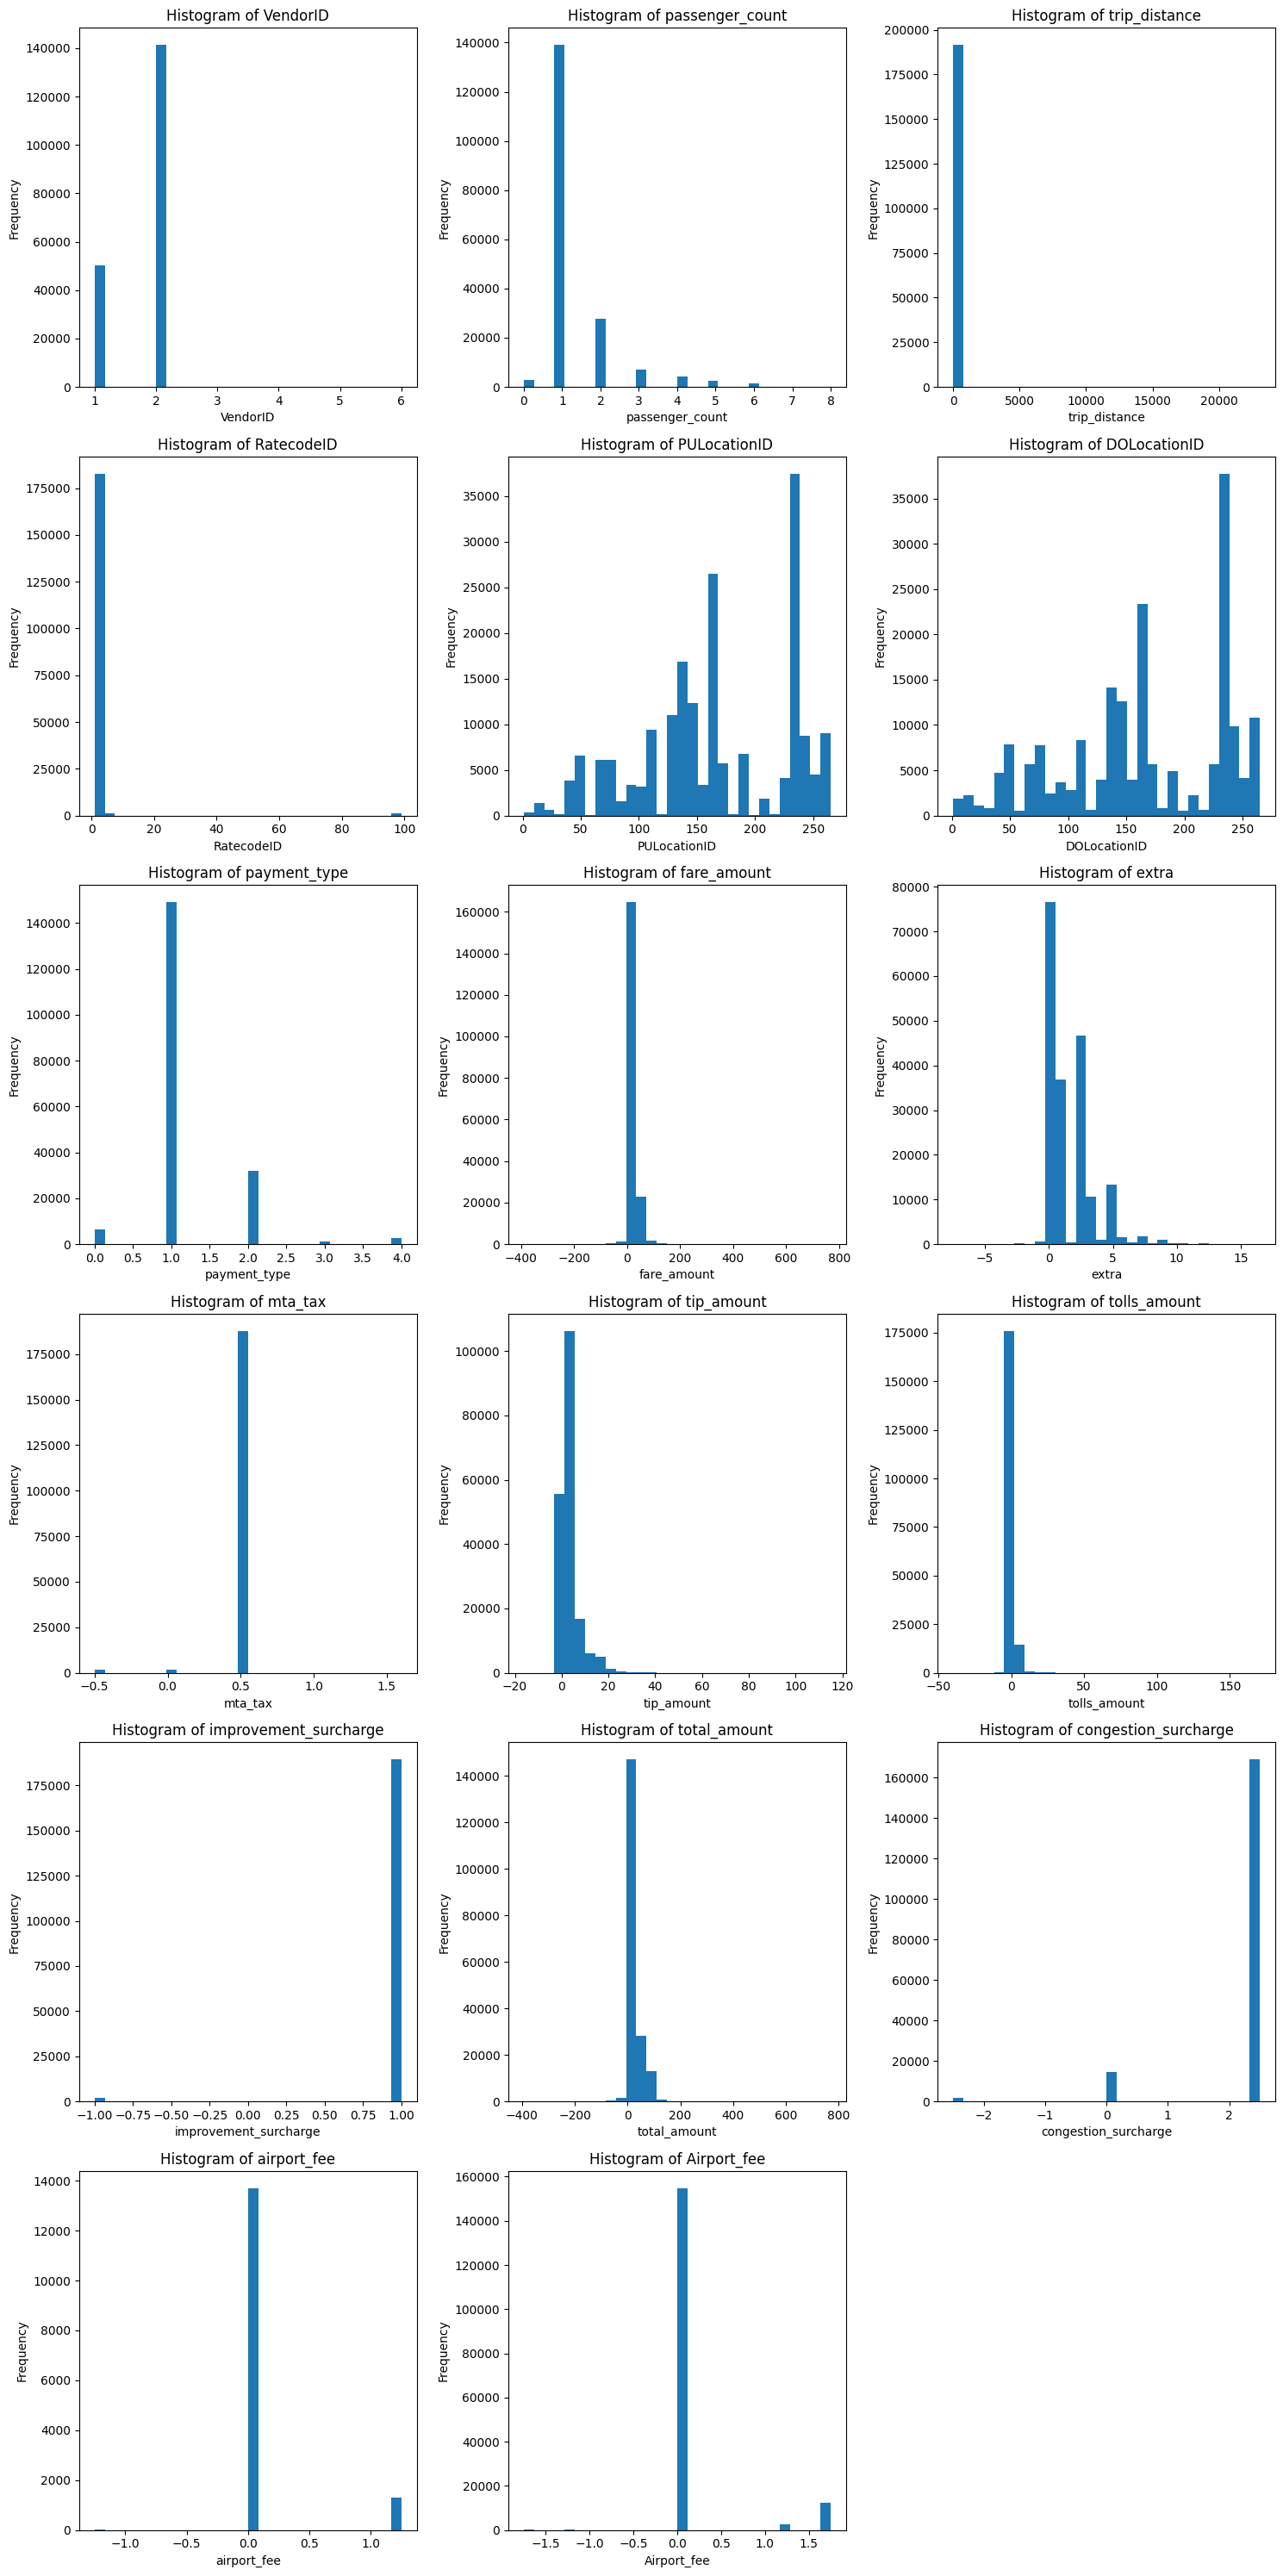

In [43]:
# prompt: plot histograms for all the features in df in subplots

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame (replace with your actual DataFrame name)
# Assuming you want to plot only numerical features.
numerical_features = combined_sample.select_dtypes(include=np.number).columns

num_plots = len(numerical_features)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, feature in enumerate(numerical_features):
    if i < num_plots:
      axes[i].hist(combined_sample[feature].dropna(), bins=30) # Drop NaN values before plotting
      axes[i].set_title(f'Histogram of {feature}')
      axes[i].set_xlabel(feature)
      axes[i].set_ylabel('Frequency')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

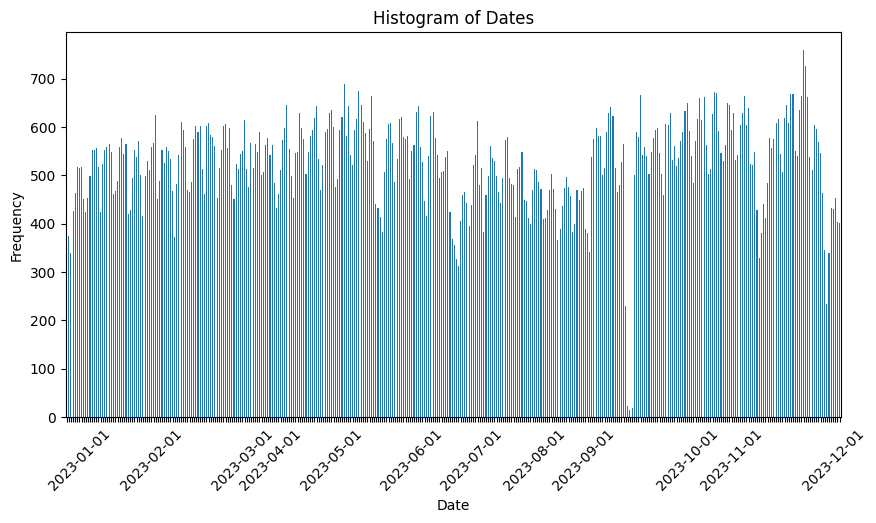

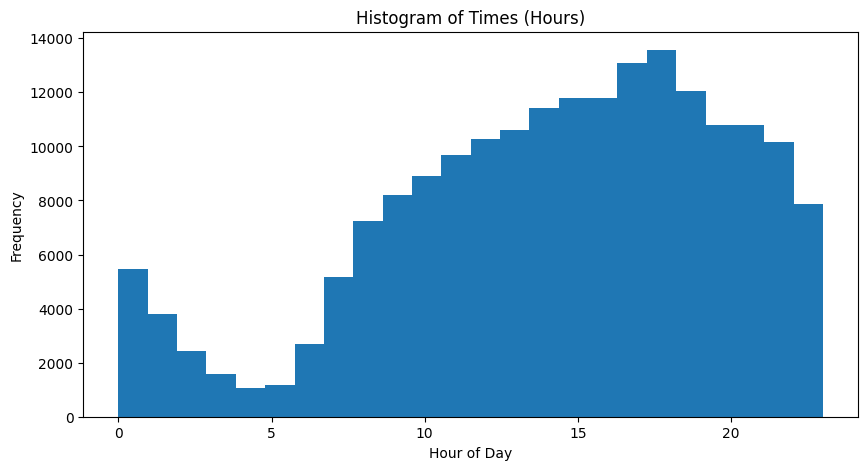

In [44]:
# Plot histogram of dates
# Sample code to plot the histogram
plt.figure(figsize=(10, 5))
combined_sample['tpep_pickup_datetime'].dt.date.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Histogram of Dates')

# Generate the list of first days of each month in the data range
date_range = combined_sample['tpep_pickup_datetime'].dt.date
first_of_month = pd.date_range(start=date_range.min(), end=date_range.max(), freq='MS').date

# Set the ticks on the x-axis to show only the first day of each month
plt.xticks(
    ticks=range(len(date_range.unique())),
    labels=[date if date in first_of_month else '' for date in date_range.unique()],
    rotation=45
)

plt.show()

# Plot histogram of times (hours) across the day
plt.figure(figsize=(10, 5))
combined_sample['tpep_pickup_datetime'].dt.hour.plot(kind='hist', bins=24)
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Histogram of Times (Hours)')
plt.show()

In [45]:
dates_below_hundred = combined_sample['tpep_pickup_datetime'].dt.date.value_counts()
dates_below_hundred = dates_below_hundred[dates_below_hundred < 100].sort_index()

# Display the dates and their frequencies
print(dates_below_hundred)

tpep_pickup_datetime
2008-12-31     1
2023-09-22    23
2023-09-23    15
2023-09-24    18
Name: count, dtype: int64


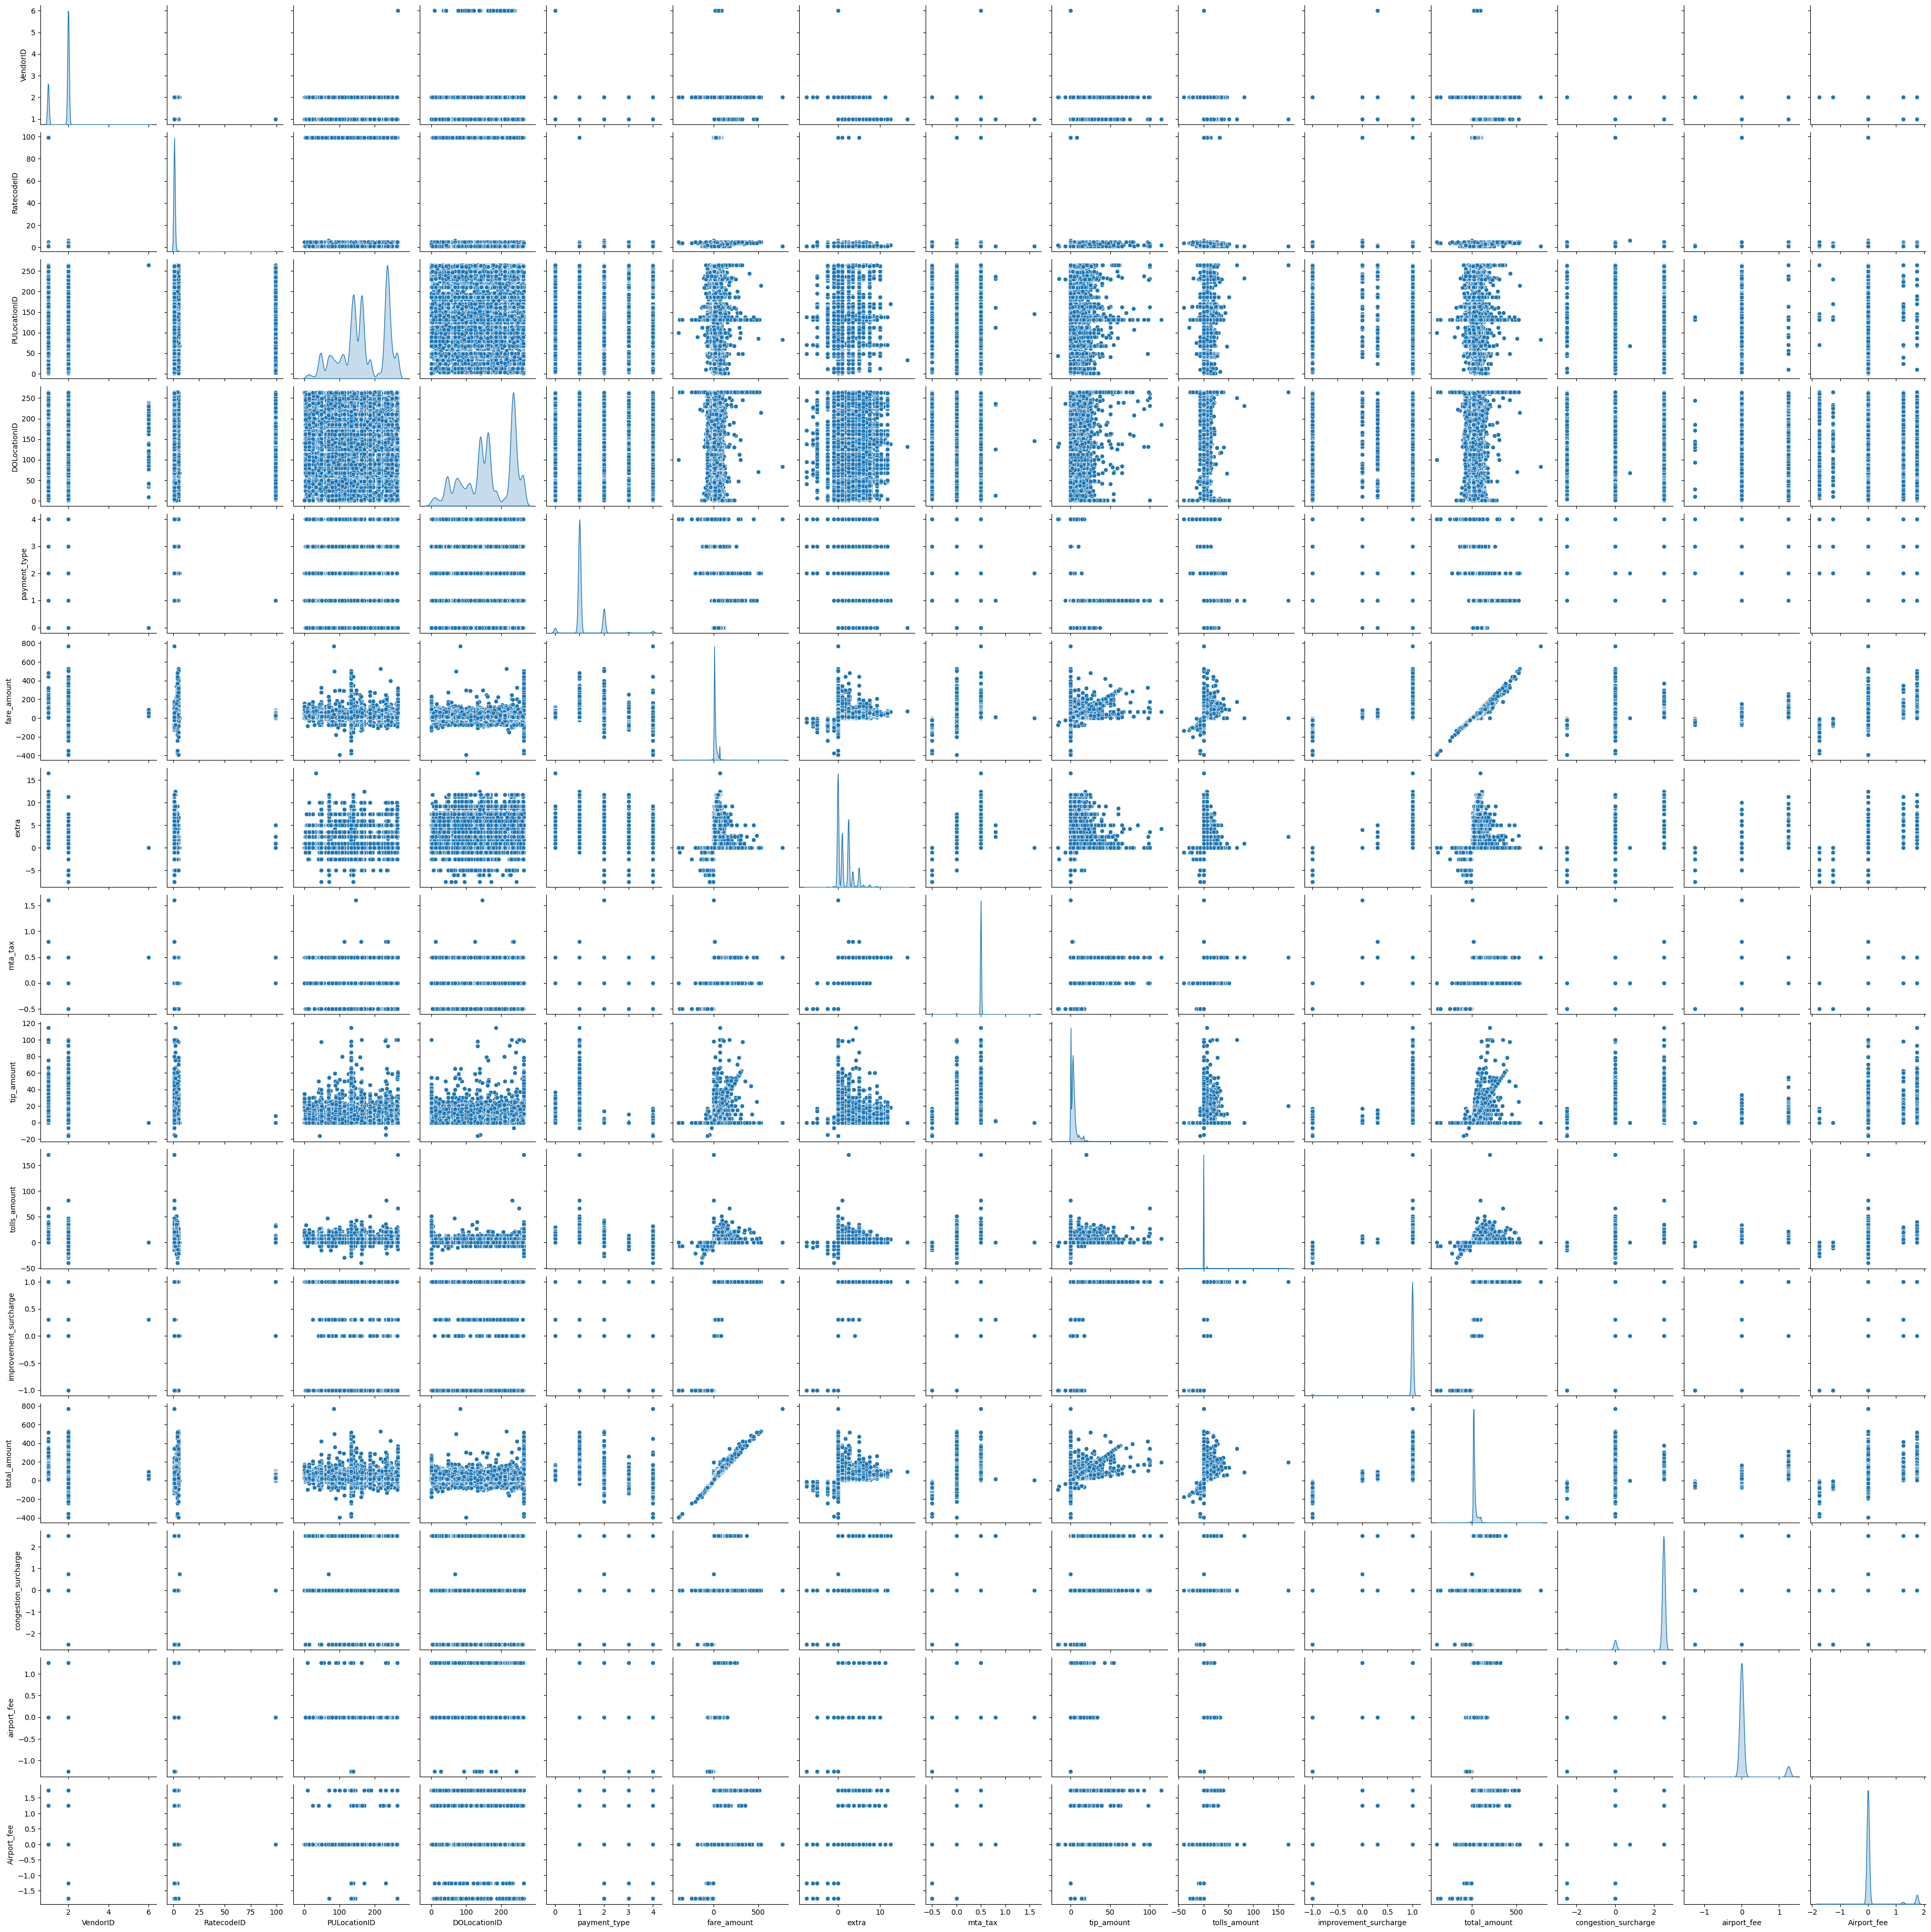

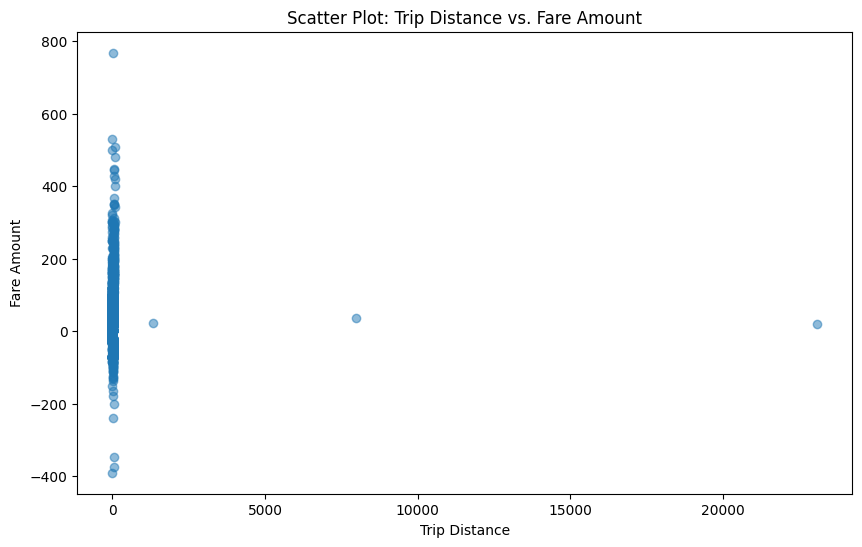

In [46]:
# prompt: plot scatters for combined_sample

# Assuming 'combined_sample' DataFrame is already created and available.

# Create scatter plots for numerical features against each other
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical features (excluding date/time)
numerical_cols = combined_sample.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('passenger_count')
numerical_cols.remove('trip_distance')

# Create pair plot
sns.pairplot(combined_sample[numerical_cols], diag_kind='kde')
plt.show()

# Location Encoding

In [5]:
file_name = '/content/drive/MyDrive/CSE151GP/data/Location_ID_encoder.xlsx'
data = pd.read_excel(file_name)

In [6]:
data

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,NaN,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island
...,...,...,...,...,...,...,...
258,256,0.067915,MULTIPOLYGON (((-73.95834207500002 40.71330630...,0.000169,Williamsburg (South Side),256,Brooklyn
259,259,0.126750,MULTIPOLYGON (((-73.85107116191898 40.91037152...,0.000395,Woodlawn/Wakefield,259,Bronx
260,260,0.133514,MULTIPOLYGON (((-73.90175373399988 40.76077547...,0.000422,Woodside,260,Queens
261,261,0.027120,MULTIPOLYGON (((-74.01332610899988 40.70503078...,0.000034,World Trade Center,261,Manhattan


In [21]:
# prompt: in 'data', print which LocationID is missing when it should be integers from 1 to 265

# Find missing LocationIDs
all_location_ids = set(range(1, 266))
present_location_ids = set(data['LocationID'].unique())

print(len(present_location_ids))
print("All instances of duplicated values:")
print(data['LocationID'][data['LocationID'].duplicated(keep=False)])

duplicated_rows = data[data['LocationID'].duplicated(keep=False)]
print(duplicated_rows)

missing_location_ids = all_location_ids - present_location_ids
print("Missing Location IDs:", missing_location_ids)

260
All instances of duplicated values:
55      56
56      56
103    103
104    103
105    103
Name: LocationID, dtype: int64
     OBJECTID  Shape_Leng                                           the_geom  \
55         56    0.056848  MULTIPOLYGON (((-73.85360568399982 40.74749682...   
56         57    0.019271  MULTIPOLYGON (((-73.8513110499998 40.749843375...   
103       103    0.014306  MULTIPOLYGON (((-74.04388559600675 40.69018482...   
104       104    0.021221  MULTIPOLYGON (((-74.03995040794244 40.70089063...   
105       105    0.077425  MULTIPOLYGON (((-74.01674756096064 40.69334336...   

     Shape_Area                                           zone  LocationID  \
55     0.000181                                         Corona          56   
56     0.000018                                         Corona          56   
103    0.000006  Governor's Island/Ellis Island/Liberty Island         103   
104    0.000012  Governor's Island/Ellis Island/Liberty Island         103   
105

In [28]:
# prompt: count how many datapoints in every df in df_list that has a POlocation or DOlocation that is any of {104, 265, 105, 264, 57, 103}

def count_datapoints(df_list, locations):
    """Counts data points in each DataFrame where 'PULocationID' or 'DOLocationID' is in the specified locations.

    Args:
        df_list: A list of pandas DataFrames.
        locations: A set of location IDs to check.

    Returns:
        A dictionary where keys are DataFrame indices and values are the counts of matching data points.
    """
    counts = {}
    for i, df in enumerate(df_list):
        # Check if necessary columns exist
        if not all(col in df.columns for col in ['PULocationID', 'DOLocationID']):
            print(f"Warning: DataFrame {i} is missing 'PULocationID' or 'DOLocationID' columns. Skipping.")
            continue

        #Efficiently count matching rows using isin() and sum()
        count = df[df['PULocationID'].isin(locations) | df['DOLocationID'].isin(locations)].shape[0]
        counts[i] = count
    return counts

# Example usage:
locations_to_check = {104, 265, 105, 264, 57, 103}
datapoint_counts = count_datapoints(df_list, locations_to_check)

print(f"Total datapoints with the missing locations: {sum(datapoint_counts.values())}")

Total datapoints with the missing locations: 438735


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    263 non-null    int64  
 1   Shape_Leng  263 non-null    float64
 2   the_geom    246 non-null    object 
 3   Shape_Area  263 non-null    float64
 4   zone        263 non-null    object 
 5   LocationID  263 non-null    int64  
 6   borough     263 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 14.5+ KB
